In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-photo/family_2.jpg
/kaggle/input/family-many/family_5.jpg
/kaggle/input/family-many/family_2.jpg
/kaggle/input/family-many/famiky_3.jpg
/kaggle/input/family-many/family_6.jpg
/kaggle/input/family-many/family_4.jpg
/kaggle/input/family-many/family.webp
/kaggle/input/ck-dataset/surprise/S071_001_00000012.png
/kaggle/input/ck-dataset/surprise/S082_001_00000013.png
/kaggle/input/ck-dataset/surprise/S116_001_00000013.png
/kaggle/input/ck-dataset/surprise/S097_001_00000020.png
/kaggle/input/ck-dataset/surprise/S085_003_00000013.png
/kaggle/input/ck-dataset/surprise/S127_001_00000015.png
/kaggle/input/ck-dataset/surprise/S085_003_00000011.png
/kaggle/input/ck-dataset/surprise/S107_001_00000008.png
/kaggle/input/ck-dataset/surprise/S138_004_00000013.png
/kaggle/input/ck-dataset/surprise/S068_003_00000013.png
/kaggle/input/ck-dataset/surprise/S126_004_00000010.png
/kaggle/input/ck-dataset/surprise/S068_003_00000014.png
/kaggle/input/ck-dataset/surprise/S090_002_00000010.png
/

In [2]:
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split

2025-07-20 14:44:56.240371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753022696.446277      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753022696.511362      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.2,
        fill_mode='nearest')

In [4]:
batch_size = 32
train_generator = datagen.flow_from_directory(
    '/kaggle/input/ck-dataset',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',   
    subset='training',
    shuffle=True
)
val_generator = datagen.flow_from_directory(
    '/kaggle/input/ck-dataset',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 788 images belonging to 7 classes.
Found 193 images belonging to 7 classes.


In [10]:
import cv2

In [5]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2025-07-20 14:45:18--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.04s   

2025-07-20 14:45:18 (24.2 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [7]:
from tensorflow.keras.applications import MobileNet

mobile_base = MobileNet(
    input_shape=(150,150, 3),  # Can change to (96, 96, 3) for faster/smaller models
    alpha=0.5,                  # Controls model size (1.0 = full, 0.5 = smaller)
    include_top=False,         # Exclude final classification layer (for custom tasks)
    weights='imagenet'         # Use pretrained ImageNet weights
)
for layer in mobile_base.layers:
    layer.trainable = False



/tmp/ipykernel_36/2260265329.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobile_base = MobileNet(
I0000 00:00:1753022726.375573      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15257 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


5577668/5577668 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
x=mobile_base.output
x = Flatten()(x)
x=Dense(256,activation="relu")(x)
x=Dropout(0.3)(x)
x=Dense(128,activation="relu")(x)
output = Dense(7,activation="softmax")(x)

In [9]:
mobile= Model(inputs=mobile_base.input, outputs=output)


In [11]:
mobile.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
movile_his =mobile.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1753022737.953982     121 service.cc:148] XLA service 0x7d9c9410ce80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753022737.954779     121 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753022738.546999     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/25 ━━━━━━━━━━━━━━━━━━━━ 3:21 8s/step - accuracy: 0.0938 - loss: 3.6019

I0000 00:00:1753022741.333749     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 654ms/step - accuracy: 0.2171 - loss: 4.8551 - val_accuracy: 0.5181 - val_loss: 1.3573
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.4825 - loss: 1.5127 - val_accuracy: 0.6218 - val_loss: 1.1428
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.5962 - loss: 1.2605 - val_accuracy: 0.5907 - val_loss: 1.1565
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.5630 - loss: 1.2707 - val_accuracy: 0.5959 - val_loss: 1.1376
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.6144 - loss: 1.1179 - val_accuracy: 0.5959 - val_loss: 1.0905
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.6297 - loss: 1.0245 - val_accuracy: 0.6062 - val_loss: 1.0652
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.6363 - loss: 0.9745 - val_accuracy: 0.6114 - val_loss: 1.0806
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.6413 - loss: 0.9829 - val_accuracy: 0.6477 - val

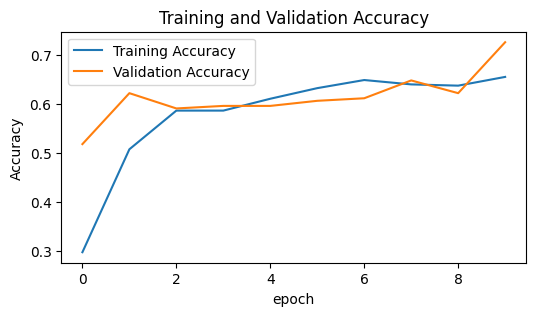

In [15]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(movile_his.history['accuracy'], label='Training Accuracy')
plt.plot(movile_his.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

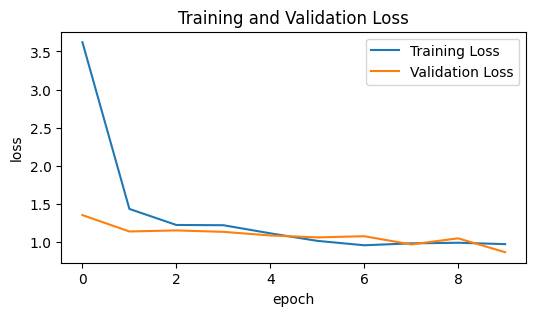

In [41]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(movile_his.history['loss'], label='Training Loss')
plt.plot(movile_his.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


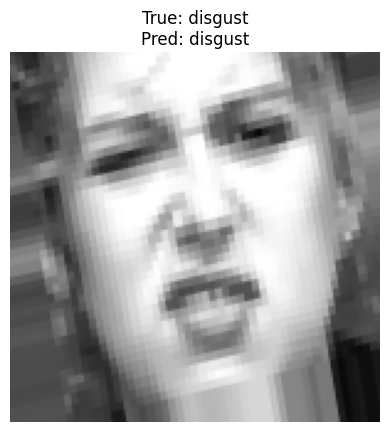

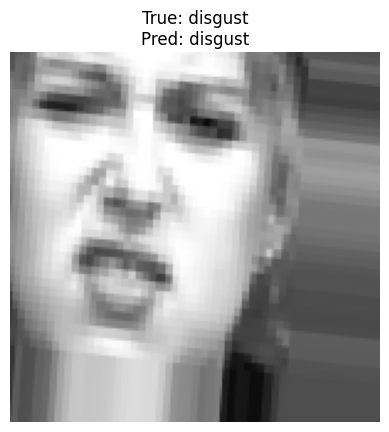

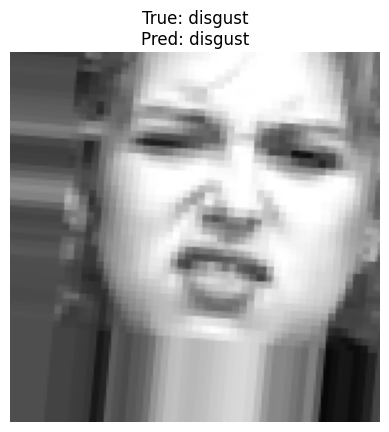

In [42]:
# Get a batch from validation generator (batch size = 32 by default)
images, labels = next(val_generator)  # images.shape = (32, 150, 150, 3)
# Predict probabilities or logits
predictions = mobile.predict(images)  # shape: (32, num_classes)
import numpy as np

# Get class labels mapping
class_indices = val_generator.class_indices
class_labels = list(class_indices.keys())

# Get predicted class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)  # if class_mode='categorical'
import matplotlib.pyplot as plt

# Show first 5 predictions
for i in range(3):
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"True: {class_labels[true_classes[i]]}\nPred: {class_labels[predicted_classes[i]]}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


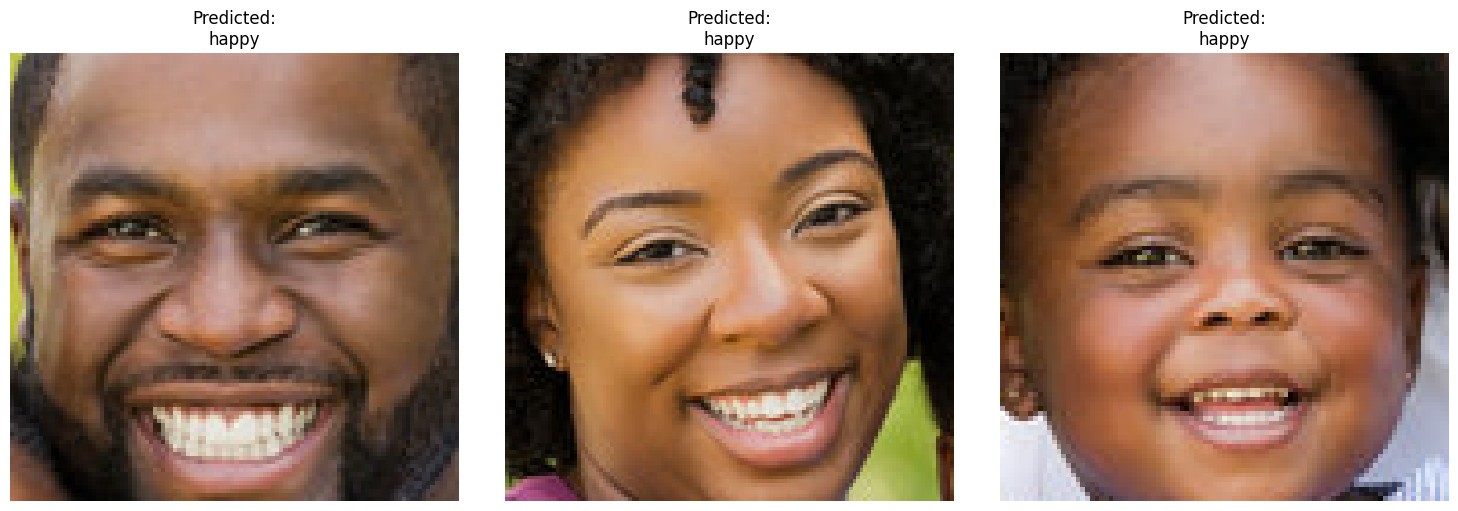

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Step 1: Load Haar cascade

face_cascade = cv2.CascadeClassifier('/kaggle/working/haarcascade_frontalface_default.xml')

# Step 2: Upload image


# Step 3: Load image and detect faces
img = cv2.imread("/kaggle/input/family-many/family_4.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray,  scaleFactor=1.03,minNeighbors=8)

# Step 4: Load your trained model
 # replace with your model file
class_indices = val_generator.class_indices
class_labels = list(class_indices.keys())

# Step 5: Predict each face
plt.figure(figsize=(15, 5))
for i, (x, y, w, h) in enumerate(faces):
    face_crop = img[y:y+h, x:x+w]
    face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
    
    # Resize to model input size
    resized_face = cv2.resize(face_rgb, (150, 150))
    input_face = resized_face.astype('float32') / 255.0
    input_face = np.expand_dims(input_face, axis=0)  # shape: (1, 150, 150, 3)

    # Predict
    prediction = mobile.predict(input_face)
    predicted_class = np.argmax(prediction[0])

    # Display
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face_rgb)
    plt.axis('off')
    plt.title(f"Predicted:\n{class_labels[predicted_class]}")

plt.tight_layout()
plt.show()
